Dimensions initiales: (713, 443)
Dimensions après nettoyage: (713, 443)

RANDOM FOREST - Meilleurs paramètres: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
F1-score (validation): 0.9576

Performance sur le test set:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       109
         1.0       0.94      0.97      0.95       105

    accuracy                           0.95       214
   macro avg       0.95      0.95      0.95       214
weighted avg       0.95      0.95      0.95       214



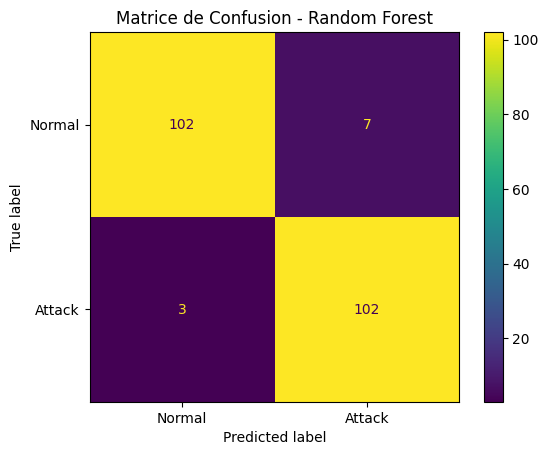

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import joblib
from sklearn.pipeline import Pipeline

# 1. Chargement et inspection des données
df = pd.read_csv('missions_fusionnees.csv')
 
print("Dimensions initiales:", df.shape)
def clean_data(df):
   
    # Conversion des booléens
    bool_cols = df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)
    
    # Conversion des chaînes de caractères
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            df[col] = df[col].replace({'True':1, 'False':0, 'true':1, 'false':0})
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                df.drop(col, axis=1, inplace=True)
    return df

df = clean_data(df)
print("Dimensions après nettoyage:", df.shape)

# 3. Feature Engineering
def create_features(df):
    # Exemples de nouvelles features
    for i in range(20):
        if f'ax_{i}' in df.columns and f'ay_{i}' in df.columns and f'az_{i}' in df.columns:
            df[f'accel_norm_{i}'] = np.sqrt(df[f'ax_{i}']**2 + df[f'ay_{i}']**2 + df[f'az_{i}']**2)
        if f'velocity_{i}' in df.columns:
            df[f'velocity_diff_{i}'] = df[f'velocity_{i}'] - df['velocity_0']
    
    # Moyennes mobiles
    for var in ['ax', 'ay', 'az']:
        for i in range(10,20):
            cols = [f'{var}_{j}' for j in range(i-5,i) if f'{var}_{j}' in df.columns]
            if cols:
                df[f'{var}_mean_last5_{i}'] = df[cols].mean(axis=1)
    return df

df = create_features(df)

# 4. Préparation des données
time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack','erreur_m'] + time_cols, axis=1, errors='ignore')
target = df['is_attack']

# 5. Pipeline de prétraitement
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = preprocessor.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42, stratify=target)

# Configuration de l'optimisation
rf_params = {
    'n_estimators': [100, 200],       # Nombre d'arbres
    'max_depth': [None, 10, 20],      # Profondeur max
    'min_samples_split': [2, 5]       # Split minimum
}

# Initialisation et optimisation
rf = RandomForestClassifier(class_weight='balanced')
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

# Meilleur modèle
best_rf = rf_grid.best_estimator_
print("\n" + "="*50)
print(f"RANDOM FOREST - Meilleurs paramètres: {rf_grid.best_params_}")
print(f"F1-score (validation): {rf_grid.best_score_:.4f}")

# Évaluation
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:,1]

# Métriques
print("\nPerformance sur le test set:")
print(classification_report(y_test, y_pred_rf))
# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['Normal', 'Attack'])
disp_rf.plot()
plt.title("Matrice de Confusion - Random Forest")
plt.show()


In [5]:
import joblib

# Sauvegarde du modèle Random Forest optimisé
joblib.dump(best_rf, 'random_forest_model.pkl')
print("✅ Modèle Random Forest sauvegardé dans 'random_forest_model.pkl'")

# Sauvegarde du préprocesseur (imputer + scaler)
joblib.dump(preprocessor, 'preprocessor_RF.pkl')
print("✅ Préprocesseur sauvegardé dans 'preprocessor.pkl'")


✅ Modèle Random Forest sauvegardé dans 'random_forest_model.pkl'
✅ Préprocesseur sauvegardé dans 'preprocessor.pkl'


In [6]:
"""
# Chargement du modèle et du préprocesseur
model = joblib.load('random_forest_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')

# Chargement et préparation des nouvelles données (exemple)
df_new = pd.read_csv('missions_fusionnees.csv')
df_new = clean_data(df_new)
df_new = create_features(df_new)

time_cols = [col for col in df_new.columns if col.startswith('time_')]
features_new = df_new.drop(['mission_id', 'is_attack', 'erreur_m'] + time_cols, axis=1, errors='ignore')

# Prétraitement
X_new = preprocessor.transform(features_new)

# Prédiction
y_pred = model.predict(X_new)
"""

"\n# Chargement du modèle et du préprocesseur\nmodel = joblib.load('random_forest_model.pkl')\npreprocessor = joblib.load('preprocessor.pkl')\n\n# Chargement et préparation des nouvelles données (exemple)\ndf_new = pd.read_csv('missions_fusionnees.csv')\ndf_new = clean_data(df_new)\ndf_new = create_features(df_new)\n\ntime_cols = [col for col in df_new.columns if col.startswith('time_')]\nfeatures_new = df_new.drop(['mission_id', 'is_attack', 'erreur_m'] + time_cols, axis=1, errors='ignore')\n\n# Prétraitement\nX_new = preprocessor.transform(features_new)\n\n# Prédiction\ny_pred = model.predict(X_new)\n"